In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import gaussian_filter, uniform_filter
from skimage.filters import threshold_otsu

import tensorflow as tf
from tensorflow.keras import layers, models

DATASET_DIR = "CdTe"  # contains train / validation / test
IMAGE_SIZE = 64
BATCH_SIZE = 16

DEFECT_CLASSES = [
    "Bulk",
    "interstitial",
    "LC",
    "SF1",
    "SF2",
    "Twin_Bound",
    "Vacancy_CdTe"
]

DEFECT_TO_IDX = {d: i for i, d in enumerate(DEFECT_CLASSES)}
NUM_DEFECTS = len(DEFECT_CLASSES)
NUM_CLASSES = NUM_DEFECTS + 1  # + background

# fixed colors for reproducibility
np.random.seed(0)
CLASS_COLORS = np.random.rand(NUM_CLASSES, 3)

def load_image(path):
    img = Image.open(path).convert("L")
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img).astype(np.float32)
    img /= img.max() + 1e-8
    return img

def make_defect_mask(img):
    """
    Weak pseudo-mask:
    highlights only strong local deviations (sparse)
    """
    img_blur = gaussian_filter(img, sigma=1)
    local_mean = uniform_filter(img_blur, size=7)
    diff = np.abs(img_blur - local_mean)

    # High-confidence threshold (IMPORTANT CHANGE)
    thresh = np.percentile(diff, 98)
    mask = diff > thresh

    return mask.astype(np.float32)

def single_defect_mask(mask, defect_name):
    y = np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_DEFECTS), dtype=np.float32)
    idx = DEFECT_TO_IDX[defect_name]
    y[..., idx] = mask
    return y

def combine_images(images):
    out = np.zeros_like(images[0])
    for img in images:
        out = np.maximum(out, img)
    return out

def combine_masks(masks):
    out = np.zeros_like(masks[0])
    for m in masks:
        out = np.maximum(out, m)
    return out

# Sample generation

def generate_sample(split="train", n_defects=2):
    defect_choices = random.sample(DEFECT_CLASSES, n_defects)

    imgs, masks = [], []

    for defect in defect_choices:
        folder = os.path.join(DATASET_DIR, split, defect)
        fname = random.choice(os.listdir(folder))
        path = os.path.join(folder, fname)

        img = load_image(path)

        # Bulk should NEVER create a defect mask
        if defect == "Bulk":
            mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.float32)
        else:
            mask = make_defect_mask(img)

        y = single_defect_mask(mask, defect)

        imgs.append(img)
        masks.append(y)

    X = combine_images(imgs)
    Y_defects = combine_masks(masks)

    # background channel
    background = 1.0 - np.max(Y_defects, axis=-1, keepdims=True)
    Y = np.concatenate([background, Y_defects], axis=-1)

    return X[..., None], Y

def data_generator(split="train"):
    while True:
        X_batch, Y_batch = [], []

        for _ in range(BATCH_SIZE):
            n = random.randint(1, 3)
            X, Y = generate_sample(split, n)
            X_batch.append(X)
            Y_batch.append(Y)

        yield np.array(X_batch), np.array(Y_batch)

# Model

def build_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)

    u2 = layers.UpSampling2D()(b)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c1])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(c4)
    return models.Model(inputs, outputs)

model = build_unet((IMAGE_SIZE, IMAGE_SIZE, 1), NUM_CLASSES)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["Accuracy", "Recall", "Precision"]
)

# Train

model.fit(
    data_generator("train"),
    steps_per_epoch=50,
    validation_data=data_generator("validation"),
    validation_steps=20,
    epochs=15
)

# Visualisation

def create_heatmap(pred):
    """
    Blended multi-class saliency heatmap
    """
    heatmap = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
    for i in range(NUM_CLASSES):
        heatmap += pred[..., i:i+1] * CLASS_COLORS[i]
    return np.clip(heatmap, 0, 1)

def plot_per_class(pred):
    """
    MUCH more interpretable than blended heatmap
    """
    class_names = ["Background"] + DEFECT_CLASSES
    for i, name in enumerate(class_names):
        plt.figure()
        plt.imshow(pred[..., i], cmap="hot")
        plt.title(name)
        plt.colorbar()
        plt.axis("off")
        plt.show()

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - Accuracy: 0.9464 - Precision: 0.8583 - Recall: 0.9563 - loss: 0.1198 - val_Accuracy: 0.9681 - val_Precision: 0.9681 - val_Recall: 0.9677 - val_loss: 0.0472
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 487ms/step - Accuracy: 0.9652 - Precision: 0.9652 - Recall: 0.9647 - loss: 0.0438 - val_Accuracy: 0.9678 - val_Precision: 0.9678 - val_Recall: 0.9675 - val_loss: 0.0375
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 437ms/step - Accuracy: 0.9665 - Precision: 0.9665 - Recall: 0.9661 - loss: 0.0365 - val_Accuracy: 0.9660 - val_Precision: 0.9660 - val_Recall: 0.9655 - val_loss: 0.0350
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - Accuracy: 0.9663 - Precision: 0.9669 - Recall: 0.9658 - loss: 0.0323 - val_Accuracy: 0.9654 - val_Precision: 0.9688 - val_Recall: 0.9636 - val_loss: 0.0309
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - Accuracy: 0.9668 - Precision: 0.9719 - Recall: 0.9640 - loss: 0.0291 - val_Accuracy: 0.9679 - val_Precis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


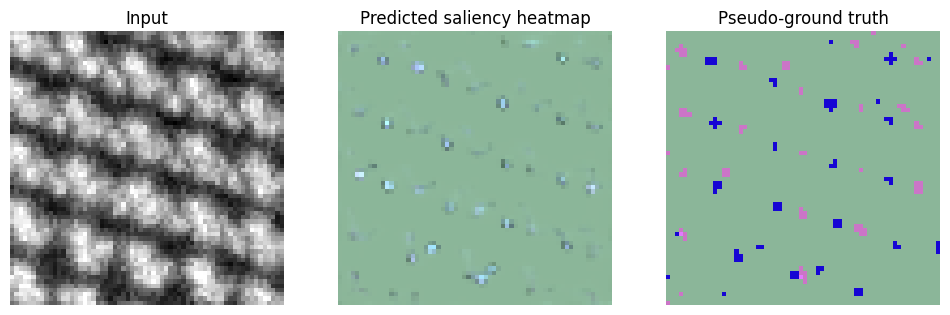

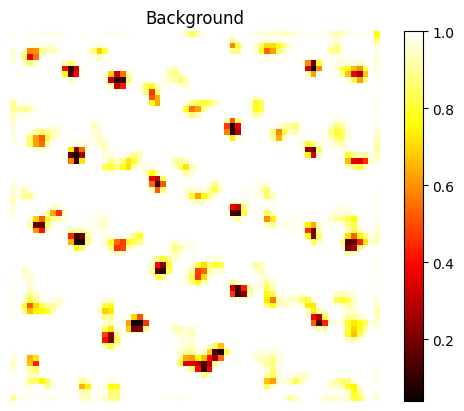

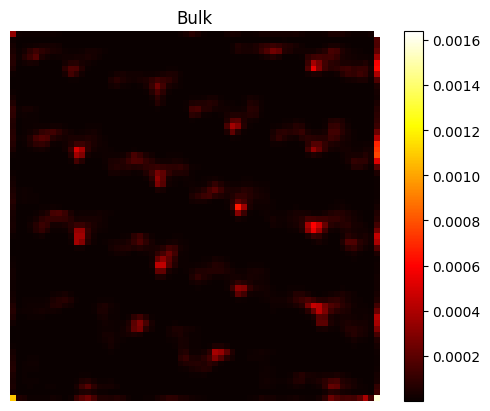

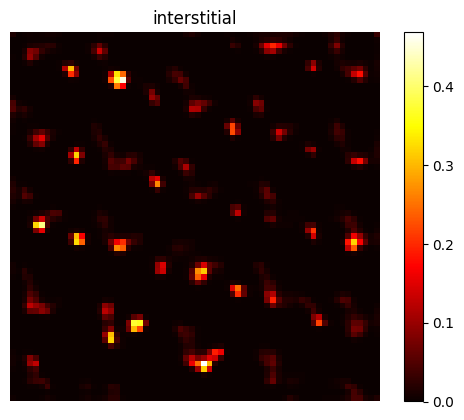

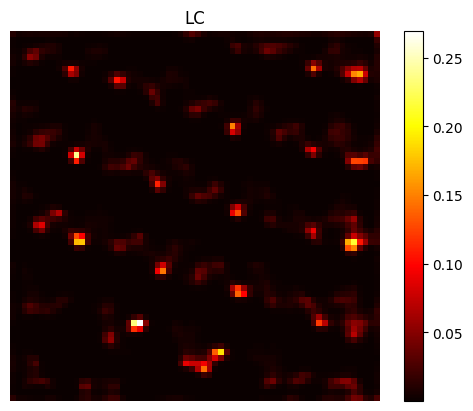

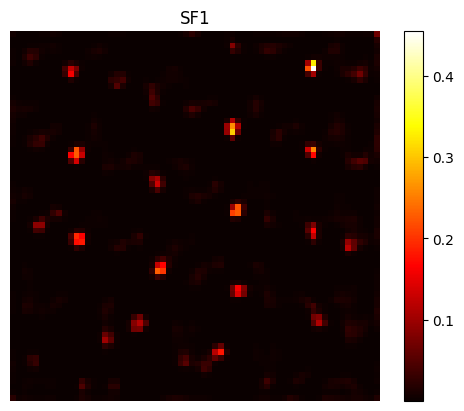

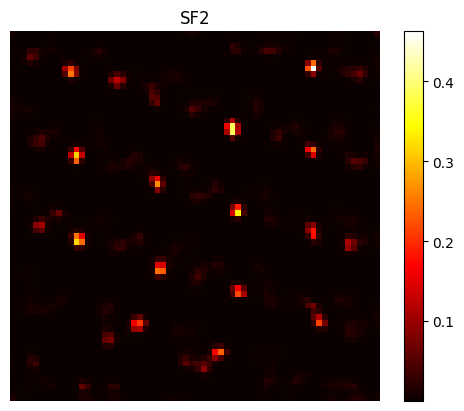

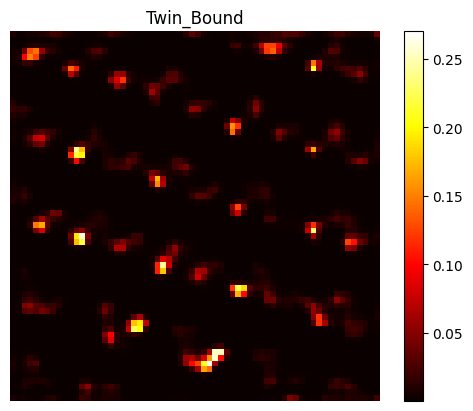

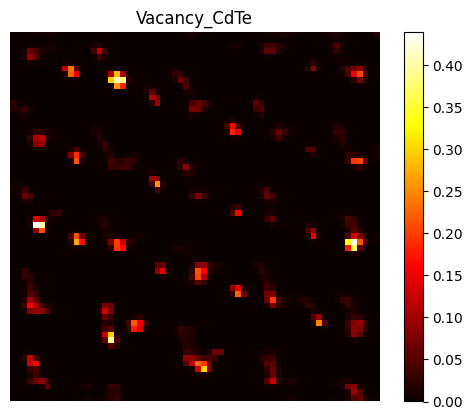

In [ ]:

# Test Sample

X, Y = generate_sample("test", n_defects=3)
pred = model.predict(X[None, ...])[0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X[..., 0], cmap="gray")
plt.title("Input")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(create_heatmap(pred))
plt.title("Predicted saliency heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(create_heatmap(Y))
plt.title("Pseudo-ground truth")
plt.axis("off")

plt.show()

# Per-class outputs
plot_per_class(pred)
